In [2]:
import numpy as np
import xarray as xr
import json
import os
import socket

import matplotlib.pyplot as plt
import matplotlib.tri as tri
from matplotlib.lines import Line2D

import xmitgcm as xm

from utils_mitgcm import open_mitgcm_ds_from_config

import eddytools as et

In [3]:
model = 'geneva_200m'

In [4]:
outputpath = "../99-Outputs/nencioli/"

# Open MITgcm results

In [5]:
mitgcm_config, ds_mitgcm = open_mitgcm_ds_from_config('../config.json', model)

In [6]:
temp_ini = ds_mitgcm.THETA.isel(time=0,Z=0)
mask = temp_ini.where(abs(temp_ini) > 1e-10).values

# Open eddy dataset

In [7]:
eddies_z0_path = r'../99-Outputs/nencioli/5th_test_eddies.nc'
xr_eddies_z0 = xr.open_dataset(eddies_z0_path)

In [8]:
eddies_z1_path = r'../99-Outputs/nencioli/Z_5m_eddies.nc'
xr_eddies_z1 = xr.open_dataset(eddies_z1_path)

# Plot functions

In [14]:
def plot_stream_velocity(ax, snapshot_vel, stream_density = 6):
    x_plot, y_plot = np.meshgrid(snapshot_vel['XC'], snapshot_vel['YC'])
    u_plot = snapshot_vel['UVEL'].values
    v_plot = snapshot_vel['VVEL'].values

    # Plot streamlines
    ax.streamplot(x_plot, y_plot, u_plot, v_plot, 
                   density=stream_density, color='black', linewidth=0.5, 
                   arrowsize=0.7, arrowstyle='->')

In [15]:
def plot_eddies(ax, snapshot_eddies, marker = 'o'):
    colors = ['gold' if t == -1 else 'green' for t in snapshot_eddies.type.values]
    ax.scatter(snapshot_eddies.lon.values, 
               snapshot_eddies.lat.values, 
               color=colors, 
               edgecolors='black',
               linewidth=1,
               marker=marker,
               s=50,
               zorder=10)

In [9]:
def plot_legend_eddy(ax):
    # Define legend handles using Line2D to mimic scatter points
    anticyclone_nencioli_handle = Line2D([], [], marker='o', color='black', markerfacecolor='gold',
                                markeredgecolor='darkred', markersize=8, linestyle='None',
                                label='z0 - Cyclone')
    
    cyclone_nencioli_handle = Line2D([], [], marker='o', color='black', markerfacecolor='green',
                            markeredgecolor='darkred', markersize=8, linestyle='None',
                            label='z0 - Anticyclone')
    
    anticyclone_ow_handle = Line2D([], [], marker='^', color='black', markerfacecolor='gold',
                                markeredgecolor='blue', markersize=8, linestyle='None',
                                label='z1 - Cyclone')
    
    cyclone_ow_handle = Line2D([], [], marker='^', color='black', markerfacecolor='green',
                            markeredgecolor='blue', markersize=8, linestyle='None',
                            label='z1 - Anticyclone')
    
    # Add to legend
    ax.legend(handles=[anticyclone_nencioli_handle, cyclone_nencioli_handle, anticyclone_ow_handle, cyclone_ow_handle], loc='upper right')

In [12]:
def plot_snapshot(t_plot, ds_mitgcm, xr_eddies_z0, xr_eddies_z1, mask):
    plt.close('all')
    fig, ax = plt.subplots(1,1,figsize=(14, 7))
    
    date_plot = ds_mitgcm.isel(time=t_plot).time.values
    snapshot_eddies_z0 = xr_eddies_z0.where(xr_eddies_z0.time == date_plot, drop=True)
    snapshot_eddies_z1 = xr_eddies_z1.where(xr_eddies_z1.time == date_plot, drop=True)

    ds_mitgcm.isel(time=t_plot, Z=0).UVEL.plot()
    
    plot_eddies(ax, snapshot_eddies_z0, 'o')
    plot_eddies(ax, snapshot_eddies_z1, '^')
    
    plot_legend_eddy(ax)

    return fig, ax

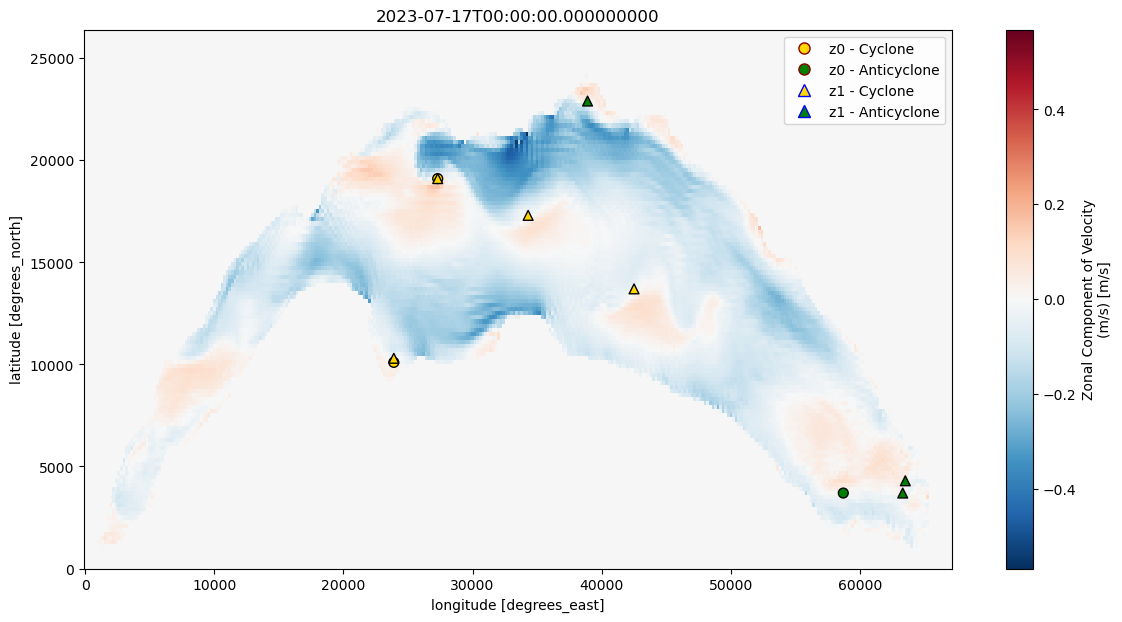

In [19]:
for t in range(len(ds_mitgcm.time.values)):
    fig, ax = plot_snapshot(t, ds_mitgcm, xr_eddies_z0, xr_eddies_z1, mask)
    ax.set_title(ds_mitgcm.isel(time=t).time.values)
    plt.savefig(rf'../99-Outputs/comparison/depth0_vs_depth5m/{model}_t{t}')

(<Figure size 1400x700 with 2 Axes>,
 <AxesSubplot: title={'center': 'Z = -0.25 [m], drF = 0.5 [m], PHrefC = 2.453 [m...'}, xlabel='longitude [degrees_east]', ylabel='latitude [degrees_north]'>)

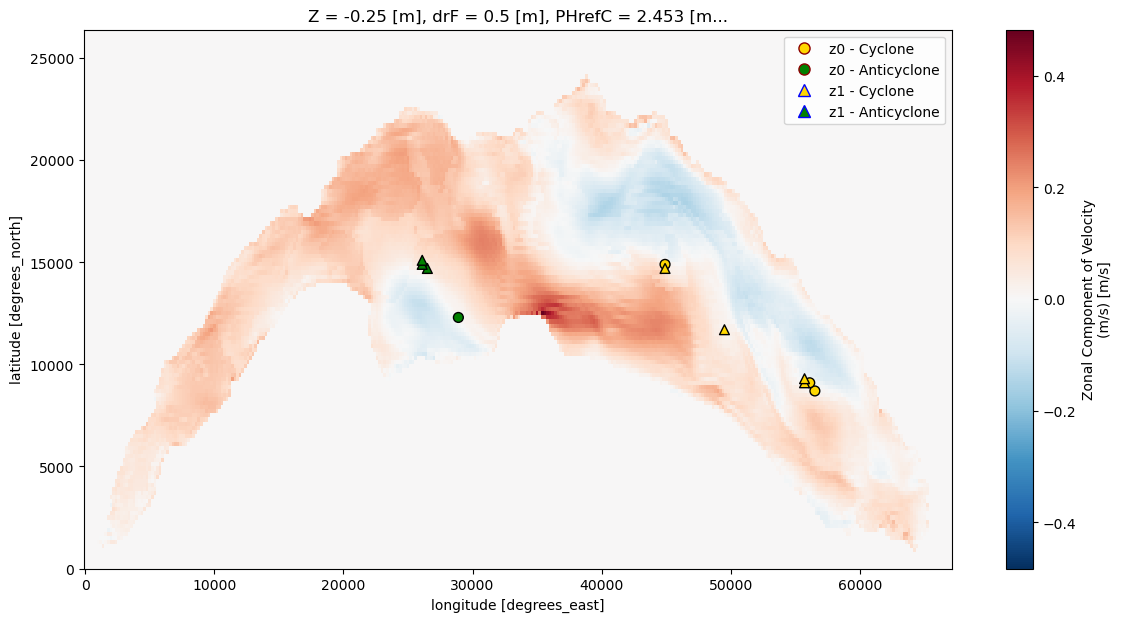

In [16]:
plot_snapshot(0, ds_mitgcm, xr_eddies_z0, xr_eddies_z1, mask)